## Job Recomendation Using Knowledge Graph

In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import chain
from collections import Counter
from sklearn.preprocessing import MultiLabelBinarizer
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpmax, fpgrowth
from mlxtend.frequent_patterns import association_rules
import seaborn as sns
import plotly.offline as pyo
import plotly.graph_objs as go
import plotly.offline as py
from plotly import tools
from plotly.offline import iplot
import warnings
warnings.filterwarnings("ignore")
import cufflinks as cf
cf.go_offline()
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings("ignore")

#### Importing Dataset

In [178]:
jd = pd.read_csv("Job Description Dataset/dice_com-job_us_sample.csv")

In [179]:
dataset = pd.read_csv("Resume_Dataset/survey_results_public.csv")

## Data Cleaning
#### Creating resume subset using relavent dimensionality

In [180]:
resume_subset= dataset[['Respondent','Country','Student','CompanySize','Dependents','DevType','Gender','JobSatisfaction','LastNewJob','Salary','SalaryType','LanguageWorkedWith','DatabaseWorkedWith','PlatformWorkedWith','FrameworkWorkedWith','OperatingSystem','Age']]
df = pd.DataFrame(resume_subset)
df

,Respondent,Country,Student,CompanySize,Dependents,DevType,Gender,JobSatisfaction,LastNewJob,Salary,SalaryType,LanguageWorkedWith,DatabaseWorkedWith,PlatformWorkedWith,FrameworkWorkedWith,OperatingSystem,Age
0,1,Kenya,No,20 to 99 employees,Yes,Full-stack developer,Male,Extremely satisfied,Less than a year ago,NaN,Monthly,JavaScript;Python;HTML;CSS,Redis;SQL Server;MySQL;PostgreSQL;Amazon RDS/A...,AWS;Azure;Linux;Firebase,Django;React,Linux-based,25 - 34 years old
1,3,United Kingdom,No,"10,000 or more employees",Yes,Database administrator;DevOps specialist;Full-...,Male,Moderately dissatisfied,More than 4 years ago,51000,Yearly,JavaScript;Python;Bash/Shell,Redis;PostgreSQL;Memcached,Linux,Django,Linux-based,35 - 44 years old
2,4,United States,No,20 to 99 employees,NaN,Engineering manager;Full-stack developer,NaN,Moderately satisfied,Less than a year ago,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,United States,No,100 to 499 employees,No,Full-stack developer,Male,Neither satisfied nor dissatisfied,Less than a year ago,NaN,NaN,C#;JavaScript;SQL;TypeScript;HTML;CSS;Bash/Shell,"SQL Server;Microsoft Azure (Tables, CosmosDB, ...",Azure,NaN,Windows,35 - 44 years old
4,7,South Africa,"Yes, part-time","10,000 or more employees",Yes,Data or business analyst;Desktop or enterprise...,Male,Slightly satisfied,Between 1 and 2 years ago,260000,Yearly,C;C++;Java;Matlab;R;SQL;Bash/Shell,SQL Server;PostgreSQL;Oracle;IBM Db2,Arduino;Windows Desktop or Server,NaN,Windows,18 - 24 years old
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98850,101513,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98851,101531,Spain,"Yes, full-time",NaN,NaN,Back-end developer;Front-end developer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98852,101541,India,"Yes, full-time",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98853,101544,Russian Federation,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Handling NA Values

In [181]:
resume_subset.isna().sum()

Respondent                 0
Country                  412
Student                 3954
CompanySize            27324
Dependents             36259
DevType                 6757
Gender                 34386
JobSatisfaction        29579
LastNewJob             19966
Salary                 48277
SalaryType             47785
LanguageWorkedWith     20521
DatabaseWorkedWith     32585
PlatformWorkedWith     32856
FrameworkWorkedWith    47235
OperatingSystem        22676
Age                    34281
dtype: int64

In [182]:
resume_subset.describe()

,Respondent
count,98855.000000
mean,50822.971635
std,29321.650410
min,1.000000
25%,25443.500000
50%,50823.000000
75%,76219.500000
max,101592.000000


In [183]:
dataset.columns

Index(['Respondent', 'Hobby', 'OpenSource', 'Country', 'Student', 'Employment',
       'FormalEducation', 'UndergradMajor', 'CompanySize', 'DevType',
       ...
       'Exercise', 'Gender', 'SexualOrientation', 'EducationParents',
       'RaceEthnicity', 'Age', 'Dependents', 'MilitaryUS', 'SurveyTooLong',
       'SurveyEasy'],
      dtype='object', length=129)

In [184]:
resume_subset.dtypes

Respondent              int64
Country                object
Student                object
CompanySize            object
Dependents             object
DevType                object
Gender                 object
JobSatisfaction        object
LastNewJob             object
Salary                 object
SalaryType             object
LanguageWorkedWith     object
DatabaseWorkedWith     object
PlatformWorkedWith     object
FrameworkWorkedWith    object
OperatingSystem        object
Age                    object
dtype: object

In [185]:
Resume= resume_subset.dropna()
Resume

,Respondent,Country,Student,CompanySize,Dependents,DevType,Gender,JobSatisfaction,LastNewJob,Salary,SalaryType,LanguageWorkedWith,DatabaseWorkedWith,PlatformWorkedWith,FrameworkWorkedWith,OperatingSystem,Age
1,3,United Kingdom,No,"10,000 or more employees",Yes,Database administrator;DevOps specialist;Full-...,Male,Moderately dissatisfied,More than 4 years ago,51000,Yearly,JavaScript;Python;Bash/Shell,Redis;PostgreSQL;Memcached,Linux,Django,Linux-based,35 - 44 years old
6,9,United States,No,"10,000 or more employees",No,Back-end developer;Front-end developer;Full-st...,Male,Slightly satisfied,Less than a year ago,120000,Yearly,JavaScript;HTML;CSS,MongoDB,Linux,Node.js;React,MacOS,18 - 24 years old
8,11,United States,No,100 to 499 employees,Yes,"Back-end developer;C-suite executive (CEO, CTO...",Male,Moderately satisfied,Between 2 and 4 years ago,250000,Yearly,Assembly;CoffeeScript;Erlang;Go;JavaScript;Lua...,Redis;PostgreSQL;Amazon DynamoDB;Apache HBase;...,Amazon Echo;AWS;iOS;Linux;Mac OS;Serverless,Hadoop;Node.js;React;Spark,MacOS,35 - 44 years old
17,27,Sweden,No,10 to 19 employees,Yes,Back-end developer,Male,Moderately satisfied,Between 1 and 2 years ago,32000,Monthly,C#;SQL;HTML;CSS;Bash/Shell,SQL Server,Linux;Windows Desktop or Server,.NET Core,Windows,35 - 44 years old
20,33,Australia,No,"1,000 to 4,999 employees",Yes,Database administrator;Full-stack developer;Mo...,Male,Slightly satisfied,Between 2 and 4 years ago,120000,Yearly,C;C++;Go;Python;SQL;Swift,Redis;PostgreSQL;SQLite,Android;AWS;iOS;Linux;Mac OS;Firebase,Angular;Node.js,MacOS,35 - 44 years old
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71512,101569,Russian Federation,No,20 to 99 employees,No,Back-end developer,Male,Extremely satisfied,Less than a year ago,100000,Monthly,Java;SQL,Redis;PostgreSQL,Linux;Windows Desktop or Server,Spring,Windows,25 - 34 years old
71513,101570,Belgium,No,20 to 99 employees,No,Back-end developer;Data or business analyst;De...,Male,Moderately satisfied,Less than a year ago,3600,Monthly,CoffeeScript;Clojure;JavaScript;PHP;Rust;SQL;H...,MongoDB;Redis;MySQL;MariaDB;Memcached,AWS;Linux;WordPress,Angular;Cordova,Linux-based,25 - 34 years old
71515,101572,Germany,No,20 to 99 employees,No,"C-suite executive (CEO, CTO, etc.);Front-end d...",Male,Extremely satisfied,Less than a year ago,2500,Monthly,CoffeeScript;JavaScript;PHP;SQL;HTML;CSS;Bash/...,MySQL,Linux;Mac OS,Node.js;React,MacOS,25 - 34 years old
71524,101584,United States,"Yes, full-time",20 to 99 employees,No,"Back-end developer;C-suite executive (CEO, CTO...",Male,Extremely satisfied,More than 4 years ago,165000,Yearly,C#;Clojure;Go;Java;JavaScript;PHP;R;SQL;HTML;C...,Redis;SQL Server;PostgreSQL;Microsoft Azure (T...,AWS;Azure;Google Cloud Platform/App Engine;Lin...,Django;Node.js;React;TensorFlow;Torch/PyTorch,MacOS,35 - 44 years old


#### Data Cleaning : DevType

In [186]:
Resume['DevType'].value_counts()

Full-stack developer                                                                                                                                                                                     1541
Back-end developer;Front-end developer;Full-stack developer                                                                                                                                              1286
Back-end developer                                                                                                                                                                                       1272
Back-end developer;Full-stack developer                                                                                                                                                                   900
Front-end developer                                                                                                                                                             

Removing dev type category having less than 100 entries in dataset

In [187]:
Resume.iloc[0]['DevType']

'Database administrator;DevOps specialist;Full-stack developer;System administrator'

In [188]:
Devtype_value= Resume['DevType'].value_counts()
Resume2= Resume.copy()
Resume2['DevType'] = Resume2['DevType'].str.replace(';',',')
Resume2['DevType'] = Resume2[[Resume2.columns[5]]].values.tolist()

for index,data in Resume2.iterrows():
    empList=[]
    array_devtype= data['DevType']
    for dev in array_devtype:
        devsplit= dev.split(',')
    Resume2.at[index,'DevType']=devsplit 
        
Resume2.iloc[0]['DevType']

['Database administrator',
 'DevOps specialist',
 'Full-stack developer',
 'System administrator']

In [189]:
DevType_co = pd.Series(Counter(chain.from_iterable(Resume2.DevType.dropna())))
DevType_co

Database administrator                            3114
DevOps specialist                                 2969
Full-stack developer                             12181
System administrator                              2389
Back-end developer                               13007
Front-end developer                               8277
C-suite executive (CEO                             596
 CTO                                               596
 etc.)                                             596
Data or business analyst                          1553
Engineering manager                               1391
Mobile developer                                  3821
Designer                                          2124
Desktop or enterprise applications developer      3661
Embedded applications or devices developer         775
Student                                           1330
Data scientist or machine learning specialist     1454
Educator or academic researcher                    524
QA or test

In [190]:
Resume2.shape[0]

18931

#### Data Cleaning : Age

In [191]:
Resume2['Age'].value_counts()

25 - 34 years old     10665
18 - 24 years old      3879
35 - 44 years old      3480
45 - 54 years old       715
55 - 64 years old       147
Under 18 years old       36
65 years or older         9
Name: Age, dtype: int64

#### Data Cleaning : Operating System

In [192]:
Resume2['OperatingSystem'].value_counts()

Windows        9112
MacOS          5865
Linux-based    3933
BSD/Unix         21
Name: OperatingSystem, dtype: int64

#### Data Cleaning : Location
Location entries having more than 50 resumes/respondents are considered

In [193]:
location= Resume2['Country'].value_counts()
location[location>50].sum()

17657

In [194]:
Resume3= Resume2[Resume2['Country'].isin(location[location>50].index)]
Resume3

,Respondent,Country,Student,CompanySize,Dependents,DevType,Gender,JobSatisfaction,LastNewJob,Salary,SalaryType,LanguageWorkedWith,DatabaseWorkedWith,PlatformWorkedWith,FrameworkWorkedWith,OperatingSystem,Age
1,3,United Kingdom,No,"10,000 or more employees",Yes,"[Database administrator, DevOps specialist, Fu...",Male,Moderately dissatisfied,More than 4 years ago,51000,Yearly,JavaScript;Python;Bash/Shell,Redis;PostgreSQL;Memcached,Linux,Django,Linux-based,35 - 44 years old
6,9,United States,No,"10,000 or more employees",No,"[Back-end developer, Front-end developer, Full...",Male,Slightly satisfied,Less than a year ago,120000,Yearly,JavaScript;HTML;CSS,MongoDB,Linux,Node.js;React,MacOS,18 - 24 years old
8,11,United States,No,100 to 499 employees,Yes,"[Back-end developer, C-suite executive (CEO, ...",Male,Moderately satisfied,Between 2 and 4 years ago,250000,Yearly,Assembly;CoffeeScript;Erlang;Go;JavaScript;Lua...,Redis;PostgreSQL;Amazon DynamoDB;Apache HBase;...,Amazon Echo;AWS;iOS;Linux;Mac OS;Serverless,Hadoop;Node.js;React;Spark,MacOS,35 - 44 years old
17,27,Sweden,No,10 to 19 employees,Yes,[Back-end developer],Male,Moderately satisfied,Between 1 and 2 years ago,32000,Monthly,C#;SQL;HTML;CSS;Bash/Shell,SQL Server,Linux;Windows Desktop or Server,.NET Core,Windows,35 - 44 years old
20,33,Australia,No,"1,000 to 4,999 employees",Yes,"[Database administrator, Full-stack developer,...",Male,Slightly satisfied,Between 2 and 4 years ago,120000,Yearly,C;C++;Go;Python;SQL;Swift,Redis;PostgreSQL;SQLite,Android;AWS;iOS;Linux;Mac OS;Firebase,Angular;Node.js,MacOS,35 - 44 years old
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71512,101569,Russian Federation,No,20 to 99 employees,No,[Back-end developer],Male,Extremely satisfied,Less than a year ago,100000,Monthly,Java;SQL,Redis;PostgreSQL,Linux;Windows Desktop or Server,Spring,Windows,25 - 34 years old
71513,101570,Belgium,No,20 to 99 employees,No,"[Back-end developer, Data or business analyst,...",Male,Moderately satisfied,Less than a year ago,3600,Monthly,CoffeeScript;Clojure;JavaScript;PHP;Rust;SQL;H...,MongoDB;Redis;MySQL;MariaDB;Memcached,AWS;Linux;WordPress,Angular;Cordova,Linux-based,25 - 34 years old
71515,101572,Germany,No,20 to 99 employees,No,"[C-suite executive (CEO, CTO, etc.), Front-e...",Male,Extremely satisfied,Less than a year ago,2500,Monthly,CoffeeScript;JavaScript;PHP;SQL;HTML;CSS;Bash/...,MySQL,Linux;Mac OS,Node.js;React,MacOS,25 - 34 years old
71524,101584,United States,"Yes, full-time",20 to 99 employees,No,"[Back-end developer, C-suite executive (CEO, ...",Male,Extremely satisfied,More than 4 years ago,165000,Yearly,C#;Clojure;Go;Java;JavaScript;PHP;R;SQL;HTML;C...,Redis;SQL Server;PostgreSQL;Microsoft Azure (T...,AWS;Azure;Google Cloud Platform/App Engine;Lin...,Django;Node.js;React;TensorFlow;Torch/PyTorch,MacOS,35 - 44 years old


In [195]:
Country_count=Resume3['Country'].unique()
len(Country_count)

46

#### Data Cleaning : Gender
Categorising Gender into Male,Female and others

In [196]:
gender_value=Resume3.groupby('Gender')['Gender'].agg('count').sort_values(ascending=False)
print(gender_value)

Gender
Male                                                                         16431
Female                                                                         977
Non-binary, genderqueer, or gender non-conforming                               68
Male;Non-binary, genderqueer, or gender non-conforming                          40
Female;Transgender                                                              38
Transgender                                                                     23
Female;Non-binary, genderqueer, or gender non-conforming                        20
Female;Male                                                                     19
Transgender;Non-binary, genderqueer, or gender non-conforming                   16
Male;Transgender                                                                12
Female;Transgender;Non-binary, genderqueer, or gender non-conforming             5
Female;Male;Transgender;Non-binary, genderqueer, or gender non-conforming       

In [197]:
gender_less_than_60= gender_value[gender_value<70]
gender_less_than_60

Gender
Non-binary, genderqueer, or gender non-conforming                            68
Male;Non-binary, genderqueer, or gender non-conforming                       40
Female;Transgender                                                           38
Transgender                                                                  23
Female;Non-binary, genderqueer, or gender non-conforming                     20
Female;Male                                                                  19
Transgender;Non-binary, genderqueer, or gender non-conforming                16
Male;Transgender                                                             12
Female;Transgender;Non-binary, genderqueer, or gender non-conforming          5
Female;Male;Transgender;Non-binary, genderqueer, or gender non-conforming     4
Female;Male;Transgender                                                       3
Female;Male;Non-binary, genderqueer, or gender non-conforming                 1
Name: Gender, dtype: int64

In [198]:
Resume3.Gender= Resume3.Gender.apply(lambda x: 'other' if x in gender_less_than_60 else x)
Resume3['Gender'].value_counts()

Male      16431
Female      977
other       249
Name: Gender, dtype: int64

### Data Cleaning : Skills
Combining 'Language' , 'Platform', 'Database' and 'Framework worked with' columns

In [199]:
# finding index no of Language Worked With column
index_no = Resume3.columns.get_loc('LanguageWorkedWith')
index_no

11

In [200]:
Resume3['LanguageWorkedWith'] = Resume3['LanguageWorkedWith'].str.replace(';',',')
Resume3['PlatformWorkedWith'] = Resume3['PlatformWorkedWith'].str.replace(';',',')
Resume3['DatabaseWorkedWith'] = Resume3['DatabaseWorkedWith'].str.replace(';',',')
Resume3['FrameworkWorkedWith'] = Resume3['FrameworkWorkedWith'].str.replace(';',',')

In [201]:
Resume3['skills'] = Resume3[['LanguageWorkedWith','PlatformWorkedWith','DatabaseWorkedWith','FrameworkWorkedWith']].values.tolist()
Resume3['skills']

1        [JavaScript,Python,Bash/Shell, Linux, Redis,Po...
6        [JavaScript,HTML,CSS, Linux, MongoDB, Node.js,...
8        [Assembly,CoffeeScript,Erlang,Go,JavaScript,Lu...
17       [C#,SQL,HTML,CSS,Bash/Shell, Linux,Windows Des...
20       [C,C++,Go,Python,SQL,Swift, Android,AWS,iOS,Li...
                               ...                        
71512    [Java,SQL, Linux,Windows Desktop or Server, Re...
71513    [CoffeeScript,Clojure,JavaScript,PHP,Rust,SQL,...
71515    [CoffeeScript,JavaScript,PHP,SQL,HTML,CSS,Bash...
71524    [C#,Clojure,Go,Java,JavaScript,PHP,R,SQL,HTML,...
71526    [C#,Go,Java,JavaScript,PHP,SQL,Swift,HTML,CSS,...
Name: skills, Length: 17657, dtype: object

In [202]:
Resume3.iloc[0]['skills']

['JavaScript,Python,Bash/Shell',
 'Linux',
 'Redis,PostgreSQL,Memcached',
 'Django']

Finding unique skills

In [203]:
for index,data in Resume3.iterrows():
    arryOfSkills=data['skills']
    megaskillslist=[]
    for skillStr in arryOfSkills:
        splitEachStr=skillStr.split(',')
        megaskillslist.extend(splitEachStr)
    for i in range (len(megaskillslist)):
        megaskillslist[i]= megaskillslist[i].lower()
    unique_list = (list(set(megaskillslist)))
    Resume3.at[index,'skills']=unique_list
Resume3.iloc[0]['skills']

['postgresql',
 'bash/shell',
 'javascript',
 'redis',
 'python',
 'linux',
 'memcached',
 'django']

In [204]:
Skills_co = pd.Series(Counter(chain.from_iterable(Resume3.skills.dropna())))
Skills_co

postgresql               6634
bash/shell               8618
javascript              14808
redis                    4152
python                   7383
                        ...  
clojure                   305
delphi/object pascal      379
hack                       50
ocaml                      83
cobol                     127
Length: 100, dtype: int64

In [205]:
for index,data in Resume3.iterrows():
    arr= data['skills']
    if arr.count(' etc)')>0:
        arr.remove(' etc)')

In [206]:
Resume3.drop(['LanguageWorkedWith', 'PlatformWorkedWith','DatabaseWorkedWith','FrameworkWorkedWith'], axis = 1)

,Respondent,Country,Student,CompanySize,Dependents,DevType,Gender,JobSatisfaction,LastNewJob,Salary,SalaryType,OperatingSystem,Age,skills
1,3,United Kingdom,No,"10,000 or more employees",Yes,"[Database administrator, DevOps specialist, Fu...",Male,Moderately dissatisfied,More than 4 years ago,51000,Yearly,Linux-based,35 - 44 years old,"[postgresql, bash/shell, javascript, redis, py..."
6,9,United States,No,"10,000 or more employees",No,"[Back-end developer, Front-end developer, Full...",Male,Slightly satisfied,Less than a year ago,120000,Yearly,MacOS,18 - 24 years old,"[mongodb, css, html, node.js, javascript, reac..."
8,11,United States,No,100 to 499 employees,Yes,"[Back-end developer, C-suite executive (CEO, ...",Male,Moderately satisfied,Between 2 and 4 years ago,250000,Yearly,MacOS,35 - 44 years old,"[go, serverless, amazon redshift, apache hbase..."
17,27,Sweden,No,10 to 19 employees,Yes,[Back-end developer],Male,Moderately satisfied,Between 1 and 2 years ago,32000,Monthly,Windows,35 - 44 years old,"[windows desktop or server, bash/shell, .net c..."
20,33,Australia,No,"1,000 to 4,999 employees",Yes,"[Database administrator, Full-stack developer,...",Male,Slightly satisfied,Between 2 and 4 years ago,120000,Yearly,MacOS,35 - 44 years old,"[postgresql, firebase, linux, go, ios, angular..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71512,101569,Russian Federation,No,20 to 99 employees,No,[Back-end developer],Male,Extremely satisfied,Less than a year ago,100000,Monthly,Windows,25 - 34 years old,"[postgresql, windows desktop or server, java, ..."
71513,101570,Belgium,No,20 to 99 employees,No,"[Back-end developer, Data or business analyst,...",Male,Moderately satisfied,Less than a year ago,3600,Monthly,Linux-based,25 - 34 years old,"[mysql, clojure, php, wordpress, cordova, memc..."
71515,101572,Germany,No,20 to 99 employees,No,"[C-suite executive (CEO, CTO, etc.), Front-e...",Male,Extremely satisfied,Less than a year ago,2500,Monthly,MacOS,25 - 34 years old,"[bash/shell, mysql, css, html, node.js, javasc..."
71524,101584,United States,"Yes, full-time",20 to 99 employees,No,"[Back-end developer, C-suite executive (CEO, ...",Male,Extremely satisfied,More than 4 years ago,165000,Yearly,MacOS,35 - 44 years old,"[google cloud storage, go, c#, serverless, clo..."


### Data Cleaning: Dependents

In [207]:
Resume3['Dependents'].value_counts()

No     12231
Yes     5426
Name: Dependents, dtype: int64

In [208]:
Resume3['Student'].value_counts()

No                14712
Yes, full-time     1743
Yes, part-time     1202
Name: Student, dtype: int64

### Data Cleaning: Salary
- Removing inconsitent data (comma)
- Converting (yearly,Weekly,Monthly) into consistent monthly salary 
- Binning salary in multiple intervals

In [209]:
Salary_count= Resume3['Salary'].value_counts()
type(Resume3['Salary'])
Salary_count.describe()

count    1948.000000
mean        9.064168
std        32.057801
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max       398.000000
Name: Salary, dtype: float64

In [210]:
Resume3['SalaryType'].value_counts()

Yearly     10103
Monthly     7171
Weekly       383
Name: SalaryType, dtype: int64

In [211]:
Resume3['Salary']=Resume3['Salary'].str.replace(',','')
Resume3['Salary']

1           51000
6          120000
8          250000
17          32000
20         120000
           ...   
71512      100000
71513        3600
71515        2500
71524      165000
71526    80000.00
Name: Salary, Length: 17657, dtype: object

In [212]:
def salary_to_monthly(x,y):
    sal = x
    typ= y
    if (typ=="Yearly"):
        #print(typ)
        return (float(sal)/12)
    if (typ=="Weekly"):
        return (float(sal)*4)
    if (typ=="Monthly"):
        return (float(sal))    



In [213]:
Resume4= Resume3.copy()
# Salary conversion

#print(salary, salarytype)
for index,data in Resume4.iterrows():
    Resume4.at[index,'Salary'] = salary_to_monthly(Resume4.at[index,'Salary'],Resume4.at[index,'SalaryType'])

Resume4.head()


,Respondent,Country,Student,CompanySize,Dependents,DevType,Gender,JobSatisfaction,LastNewJob,Salary,SalaryType,LanguageWorkedWith,DatabaseWorkedWith,PlatformWorkedWith,FrameworkWorkedWith,OperatingSystem,Age,skills
1,3,United Kingdom,No,"10,000 or more employees",Yes,"[Database administrator, DevOps specialist, Fu...",Male,Moderately dissatisfied,More than 4 years ago,4250.0,Yearly,"JavaScript,Python,Bash/Shell","Redis,PostgreSQL,Memcached",Linux,Django,Linux-based,35 - 44 years old,"[postgresql, bash/shell, javascript, redis, py..."
6,9,United States,No,"10,000 or more employees",No,"[Back-end developer, Front-end developer, Full...",Male,Slightly satisfied,Less than a year ago,10000.0,Yearly,"JavaScript,HTML,CSS",MongoDB,Linux,"Node.js,React",MacOS,18 - 24 years old,"[mongodb, css, html, node.js, javascript, reac..."
8,11,United States,No,100 to 499 employees,Yes,"[Back-end developer, C-suite executive (CEO, ...",Male,Moderately satisfied,Between 2 and 4 years ago,20833.333333,Yearly,"Assembly,CoffeeScript,Erlang,Go,JavaScript,Lua...","Redis,PostgreSQL,Amazon DynamoDB,Apache HBase,...","Amazon Echo,AWS,iOS,Linux,Mac OS,Serverless","Hadoop,Node.js,React,Spark",MacOS,35 - 44 years old,"[go, serverless, amazon redshift, apache hbase..."
17,27,Sweden,No,10 to 19 employees,Yes,[Back-end developer],Male,Moderately satisfied,Between 1 and 2 years ago,32000.0,Monthly,"C#,SQL,HTML,CSS,Bash/Shell",SQL Server,"Linux,Windows Desktop or Server",.NET Core,Windows,35 - 44 years old,"[windows desktop or server, bash/shell, .net c..."
20,33,Australia,No,"1,000 to 4,999 employees",Yes,"[Database administrator, Full-stack developer,...",Male,Slightly satisfied,Between 2 and 4 years ago,10000.0,Yearly,"C,C++,Go,Python,SQL,Swift","Redis,PostgreSQL,SQLite","Android,AWS,iOS,Linux,Mac OS,Firebase","Angular,Node.js",MacOS,35 - 44 years old,"[postgresql, firebase, linux, go, ios, angular..."


In [214]:
Salary= Resume4['Salary']
print(min(Salary))
print(Salary.max())
print(sum(Salary))
print(sum(Salary)/len(Salary))

0.0
8.333333333333333e+33
8.334333333333333e+33
4.7201298823884765e+29


Binning into salary catergories

In [215]:
Salary_Category= pd.cut(Resume4.Salary, bins=[500,1500,5000,10000,16000,30000,45000,63000,79000,89000,100000], labels=['500-1500','1501-5000','5001-10000','10001-16000','16001-30000','30001-45000','45001-63000','63001-79000','79001-89000','89001-100000'] )
try:
    Resume4.insert(9,'Salary_group',Salary_Category)
except:
    print("Salary Group already exist!")

In [216]:
Resume4['Salary_group']
Resume4['Salary']

1              4250.0
6             10000.0
8        20833.333333
17            32000.0
20            10000.0
             ...     
71512        100000.0
71513          3600.0
71515          2500.0
71524         13750.0
71526     6666.666667
Name: Salary, Length: 17657, dtype: object

In [217]:
Resume4['Salary_group'].value_counts()

1501-5000       5081
5001-10000      4884
10001-16000     1819
16001-30000     1029
30001-45000      976
500-1500         797
45001-63000      692
63001-79000      355
89001-100000     219
79001-89000      186
Name: Salary_group, dtype: int64

In [218]:
Resume4['Salary_group'].isna().sum()
# drop na values i.e. remove outliers from salary
Resume5= Resume4.dropna()
Resume5.head()


,Respondent,Country,Student,CompanySize,Dependents,DevType,Gender,JobSatisfaction,LastNewJob,Salary_group,Salary,SalaryType,LanguageWorkedWith,DatabaseWorkedWith,PlatformWorkedWith,FrameworkWorkedWith,OperatingSystem,Age,skills
1,3,United Kingdom,No,"10,000 or more employees",Yes,"[Database administrator, DevOps specialist, Fu...",Male,Moderately dissatisfied,More than 4 years ago,1501-5000,4250.0,Yearly,"JavaScript,Python,Bash/Shell","Redis,PostgreSQL,Memcached",Linux,Django,Linux-based,35 - 44 years old,"[postgresql, bash/shell, javascript, redis, py..."
6,9,United States,No,"10,000 or more employees",No,"[Back-end developer, Front-end developer, Full...",Male,Slightly satisfied,Less than a year ago,5001-10000,10000.0,Yearly,"JavaScript,HTML,CSS",MongoDB,Linux,"Node.js,React",MacOS,18 - 24 years old,"[mongodb, css, html, node.js, javascript, reac..."
8,11,United States,No,100 to 499 employees,Yes,"[Back-end developer, C-suite executive (CEO, ...",Male,Moderately satisfied,Between 2 and 4 years ago,16001-30000,20833.333333,Yearly,"Assembly,CoffeeScript,Erlang,Go,JavaScript,Lua...","Redis,PostgreSQL,Amazon DynamoDB,Apache HBase,...","Amazon Echo,AWS,iOS,Linux,Mac OS,Serverless","Hadoop,Node.js,React,Spark",MacOS,35 - 44 years old,"[go, serverless, amazon redshift, apache hbase..."
17,27,Sweden,No,10 to 19 employees,Yes,[Back-end developer],Male,Moderately satisfied,Between 1 and 2 years ago,30001-45000,32000.0,Monthly,"C#,SQL,HTML,CSS,Bash/Shell",SQL Server,"Linux,Windows Desktop or Server",.NET Core,Windows,35 - 44 years old,"[windows desktop or server, bash/shell, .net c..."
20,33,Australia,No,"1,000 to 4,999 employees",Yes,"[Database administrator, Full-stack developer,...",Male,Slightly satisfied,Between 2 and 4 years ago,5001-10000,10000.0,Yearly,"C,C++,Go,Python,SQL,Swift","Redis,PostgreSQL,SQLite","Android,AWS,iOS,Linux,Mac OS,Firebase","Angular,Node.js",MacOS,35 - 44 years old,"[postgresql, firebase, linux, go, ios, angular..."


In [219]:
analysis_data1= Resume5.groupby(['Age','Gender'])['skills']
analysis_data1

In [220]:
for x in analysis_data1:
    skill_count = pd.Series(Counter(chain.from_iterable(x[1].dropna()))).sort_values(ascending=False)
    print(x[0],skill_count)


('18 - 24 years old', 'Female') html                       139
css                        137
javascript                 136
sql                        114
mysql                      104
                          ... 
f#                           1
gaming console               1
delphi/object pascal         1
apple watch or apple tv      1
mainframe                    1
Length: 93, dtype: int64
('18 - 24 years old', 'Male') javascript    2555
html          2440
css           2388
sql           2014
mysql         1958
              ... 
cobol           24
mainframe       21
julia           17
hack            14
predix           2
Length: 99, dtype: int64
('18 - 24 years old', 'other') css           55
html          55
javascript    50
node.js       41
sql           40
              ..
ocaml          1
f#             1
esp8266        1
spark          1
erlang         1
Length: 91, dtype: int64
('25 - 34 years old', 'Female') javascript    488
html          467
css           454
sql      

In [221]:
analysis_data2= Resume5.groupby(['Age','Gender'])['DevType']
analysis_data2

In [222]:
for x in analysis_data2:
    DevType_count = pd.Series(Counter(chain.from_iterable(x[1].dropna()))).sort_values(ascending=False)
    print(x[0],DevType_count)


('18 - 24 years old', 'Female') Back-end developer                               101
Full-stack developer                              88
Front-end developer                               74
Student                                           35
Mobile developer                                  29
Designer                                          20
Database administrator                            19
Desktop or enterprise applications developer      18
QA or test developer                              14
DevOps specialist                                 14
Data scientist or machine learning specialist     12
System administrator                              11
Data or business analyst                           8
Educator or academic researcher                    5
Embedded applications or devices developer         2
Product manager                                    2
C-suite executive (CEO                             1
 CTO                                               1
 etc.)        

Text(0, 0.5, 'Resume5')

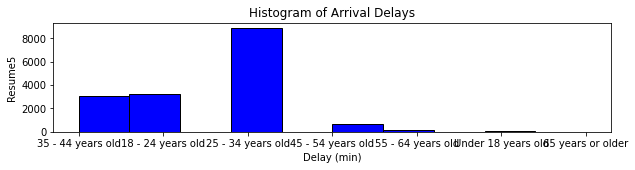

In [223]:
# matplotlib histogram
plt.hist(Resume5['Age'], color = 'blue', edgecolor = 'black')

# seaborn histogram
# sns.distplot(Resume4['Age'], hist=True, kde=False,color = 'blue',hist_kws={'edgecolor':'black'})
# Add labels
plt.rcParams['figure.figsize']=[10,2]
plt.title('Histogram of Arrival Delays')
plt.xlabel('Delay (min)')
plt.ylabel('Resume5')


In [224]:
pd.crosstab(Resume5['Age'],Resume5['Gender']).apply(lambda r: r*100/r.sum(), axis=1)

Gender,Female,Male,other
Age,,,
18 - 24 years old,5.246818,92.890407,1.862776
25 - 34 years old,6.559225,91.975656,1.465119
35 - 44 years old,4.221721,94.424750,1.353529
45 - 54 years old,4.191617,95.059880,0.748503
55 - 64 years old,3.597122,94.964029,1.438849
65 years or older,0.000000,100.000000,0.000000
Under 18 years old,0.000000,100.000000,0.000000


In [225]:
pd.crosstab(Resume5['Age'],Resume5['Salary_group']).apply(lambda r: r*100/r.sum(), axis=1)

Salary_group,500-1500,1501-5000,5001-10000,10001-16000,16001-30000,30001-45000,45001-63000,63001-79000,79001-89000,89001-100000
Age,,,,,,,,,,
18 - 24 years old,13.505123,37.038187,19.900652,5.246818,10.090034,6.643899,3.415088,2.049053,0.900342,1.210804
25 - 34 years old,3.426124,33.618844,31.037980,9.275330,5.623803,6.829708,4.868703,2.400541,1.284797,1.634171
35 - 44 years old,1.063487,25.233645,37.093136,19.658395,4.898485,4.157267,3.996133,1.965840,1.095714,0.837899
45 - 54 years old,0.748503,14.970060,42.215569,25.299401,6.437126,3.293413,2.844311,1.946108,1.197605,1.047904
55 - 64 years old,0.719424,10.071942,37.410072,33.093525,6.474820,3.597122,5.035971,1.438849,0.719424,1.438849
65 years or older,0.000000,0.000000,57.142857,28.571429,14.285714,0.000000,0.000000,0.000000,0.000000,0.000000
Under 18 years old,70.370370,29.629630,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [226]:
analysis = Resume5.groupby('Age')['Gender'].value_counts()
analysis

Age                 Gender
18 - 24 years old   Male      2992
                    Female     169
                    other       60
25 - 34 years old   Male      8161
                    Female     582
                    other      130
35 - 44 years old   Male      2930
                    Female     131
                    other       42
45 - 54 years old   Male       635
                    Female      28
                    other        5
55 - 64 years old   Male       132
                    Female       5
                    other        2
65 years or older   Male         7
Under 18 years old  Male        27
Name: Gender, dtype: int64

In [227]:
Resume5

,Respondent,Country,Student,CompanySize,Dependents,DevType,Gender,JobSatisfaction,LastNewJob,Salary_group,Salary,SalaryType,LanguageWorkedWith,DatabaseWorkedWith,PlatformWorkedWith,FrameworkWorkedWith,OperatingSystem,Age,skills
1,3,United Kingdom,No,"10,000 or more employees",Yes,"[Database administrator, DevOps specialist, Fu...",Male,Moderately dissatisfied,More than 4 years ago,1501-5000,4250.0,Yearly,"JavaScript,Python,Bash/Shell","Redis,PostgreSQL,Memcached",Linux,Django,Linux-based,35 - 44 years old,"[postgresql, bash/shell, javascript, redis, py..."
6,9,United States,No,"10,000 or more employees",No,"[Back-end developer, Front-end developer, Full...",Male,Slightly satisfied,Less than a year ago,5001-10000,10000.0,Yearly,"JavaScript,HTML,CSS",MongoDB,Linux,"Node.js,React",MacOS,18 - 24 years old,"[mongodb, css, html, node.js, javascript, reac..."
8,11,United States,No,100 to 499 employees,Yes,"[Back-end developer, C-suite executive (CEO, ...",Male,Moderately satisfied,Between 2 and 4 years ago,16001-30000,20833.333333,Yearly,"Assembly,CoffeeScript,Erlang,Go,JavaScript,Lua...","Redis,PostgreSQL,Amazon DynamoDB,Apache HBase,...","Amazon Echo,AWS,iOS,Linux,Mac OS,Serverless","Hadoop,Node.js,React,Spark",MacOS,35 - 44 years old,"[go, serverless, amazon redshift, apache hbase..."
17,27,Sweden,No,10 to 19 employees,Yes,[Back-end developer],Male,Moderately satisfied,Between 1 and 2 years ago,30001-45000,32000.0,Monthly,"C#,SQL,HTML,CSS,Bash/Shell",SQL Server,"Linux,Windows Desktop or Server",.NET Core,Windows,35 - 44 years old,"[windows desktop or server, bash/shell, .net c..."
20,33,Australia,No,"1,000 to 4,999 employees",Yes,"[Database administrator, Full-stack developer,...",Male,Slightly satisfied,Between 2 and 4 years ago,5001-10000,10000.0,Yearly,"C,C++,Go,Python,SQL,Swift","Redis,PostgreSQL,SQLite","Android,AWS,iOS,Linux,Mac OS,Firebase","Angular,Node.js",MacOS,35 - 44 years old,"[postgresql, firebase, linux, go, ios, angular..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71512,101569,Russian Federation,No,20 to 99 employees,No,[Back-end developer],Male,Extremely satisfied,Less than a year ago,89001-100000,100000.0,Monthly,"Java,SQL","Redis,PostgreSQL","Linux,Windows Desktop or Server",Spring,Windows,25 - 34 years old,"[postgresql, windows desktop or server, java, ..."
71513,101570,Belgium,No,20 to 99 employees,No,"[Back-end developer, Data or business analyst,...",Male,Moderately satisfied,Less than a year ago,1501-5000,3600.0,Monthly,"CoffeeScript,Clojure,JavaScript,PHP,Rust,SQL,H...","MongoDB,Redis,MySQL,MariaDB,Memcached","AWS,Linux,WordPress","Angular,Cordova",Linux-based,25 - 34 years old,"[mysql, clojure, php, wordpress, cordova, memc..."
71515,101572,Germany,No,20 to 99 employees,No,"[C-suite executive (CEO, CTO, etc.), Front-e...",Male,Extremely satisfied,Less than a year ago,1501-5000,2500.0,Monthly,"CoffeeScript,JavaScript,PHP,SQL,HTML,CSS,Bash/...",MySQL,"Linux,Mac OS","Node.js,React",MacOS,25 - 34 years old,"[bash/shell, mysql, css, html, node.js, javasc..."
71524,101584,United States,"Yes, full-time",20 to 99 employees,No,"[Back-end developer, C-suite executive (CEO, ...",Male,Extremely satisfied,More than 4 years ago,10001-16000,13750.0,Yearly,"C#,Clojure,Go,Java,JavaScript,PHP,R,SQL,HTML,C...","Redis,SQL Server,PostgreSQL,Microsoft Azure (T...","AWS,Azure,Google Cloud Platform/App Engine,Lin...","Django,Node.js,React,TensorFlow,Torch/PyTorch",MacOS,35 - 44 years old,"[google cloud storage, go, c#, serverless, clo..."


In [228]:
sub= Resume5[['Respondent','skills']]
aprioriData1 = pd.DataFrame(sub)
aprioriData1


,Respondent,skills
1,3,"[postgresql, bash/shell, javascript, redis, py..."
6,9,"[mongodb, css, html, node.js, javascript, reac..."
8,11,"[go, serverless, amazon redshift, apache hbase..."
17,27,"[windows desktop or server, bash/shell, .net c..."
20,33,"[postgresql, firebase, linux, go, ios, angular..."
...,...,...
71512,101569,"[postgresql, windows desktop or server, java, ..."
71513,101570,"[mysql, clojure, php, wordpress, cordova, memc..."
71515,101572,"[bash/shell, mysql, css, html, node.js, javasc..."
71524,101584,"[google cloud storage, go, c#, serverless, clo..."


['mysql', 'css', 'html', 'node.js', 'sql', 'bash/shell', 'php'] -> ['javascript'] = 100.0%
<br>
['windows desktop or server', 'sql', 'javascript', 'c#', '.net core', 'css', 'sql server'] -> ['html'] = 97.91666666666666%
<br>
['mysql', 'linux', 'node.js', 'sql', 'javascript', 'bash/shell', 'css'] -> ['html'] = 97.5%


In [229]:
sub= Resume5[['Respondent','DevType']]
aprioriData2 = pd.DataFrame(sub)
aprioriData2

,Respondent,DevType
1,3,"[Database administrator, DevOps specialist, Fu..."
6,9,"[Back-end developer, Front-end developer, Full..."
8,11,"[Back-end developer, C-suite executive (CEO, ..."
17,27,[Back-end developer]
20,33,"[Database administrator, Full-stack developer,..."
...,...,...
71512,101569,[Back-end developer]
71513,101570,"[Back-end developer, Data or business analyst,..."
71515,101572,"[C-suite executive (CEO, CTO, etc.), Front-e..."
71524,101584,"[Back-end developer, C-suite executive (CEO, ..."


FP Growth on Skills

In [230]:
apridataD = []
# Only take first 500 rows
count=11919;
for index,data in Resume5.iterrows():
    eachapridata=[]
    # eachapridata.append(data['skills'])
    apridataD.append(data['skills'])
    count-=1
    if(count<=0):
        break
# print(apridataD)
data=apridataD
data

[['postgresql',
  'bash/shell',
  'javascript',
  'redis',
  'python',
  'linux',
  'memcached',
  'django'],
 ['mongodb', 'css', 'html', 'node.js', 'javascript', 'react', 'linux'],
 ['go',
  'serverless',
  'amazon redshift',
  'apache hbase',
  'python',
  'amazon rds/aurora',
  'hadoop',
  'erlang',
  'amazon echo',
  'node.js',
  'aws',
  'assembly',
  'redis',
  'linux',
  'amazon dynamodb',
  'bash/shell',
  'html',
  'apache hive',
  'javascript',
  'ruby',
  'sql',
  'lua',
  'coffeescript',
  'elasticsearch',
  'postgresql',
  'ios',
  'css',
  'spark',
  'mac os',
  'react'],
 ['windows desktop or server',
  'bash/shell',
  '.net core',
  'c#',
  'css',
  'html',
  'sql server',
  'sql',
  'linux'],
 ['postgresql',
  'firebase',
  'linux',
  'go',
  'ios',
  'angular',
  'c++',
  'c',
  'node.js',
  'sql',
  'mac os',
  'aws',
  'python',
  'redis',
  'android',
  'sqlite',
  'swift'],
 ['firebase',
  'java',
  'ios',
  'mysql',
  'angular',
  'c++',
  'android',
  'c',
  'ja

In [231]:
te = TransactionEncoder()
te_ary = te.fit(data).transform(data)
df = pd.DataFrame(te_ary, columns=te.columns_)

frequent_itemsets = fpgrowth(df, min_support=0.2, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.844534,(javascript)
1,0.495511,(bash/shell)
2,0.487373,(linux)
3,0.417820,(python)
4,0.376122,(postgresql)
...,...,...
469,0.200772,"(typescript, angular)"
470,0.244651,"(typescript, javascript, html)"
471,0.244232,"(typescript, css, html)"
472,0.242386,"(typescript, css, javascript)"


In [232]:
association_rules(frequent_itemsets, metric="confidence", min_threshold=0.9
)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(javascript, bash/shell)",(html),0.432503,0.786391,0.394664,0.912512,1.160379,0.054548,2.441579
1,"(bash/shell, html)",(javascript),0.417652,0.844534,0.394664,0.944958,1.118910,0.041942,2.824489
2,"(css, bash/shell)",(html),0.406410,0.786391,0.400621,0.985756,1.253518,0.081024,14.995938
3,"(bash/shell, html)",(css),0.417652,0.763487,0.400621,0.959221,1.256368,0.081749,5.799815
4,"(css, bash/shell)",(javascript),0.406410,0.844534,0.387281,0.952931,1.128352,0.044054,3.302972
...,...,...,...,...,...,...,...,...,...
568,"(typescript, css, javascript)",(html),0.242386,0.786391,0.237939,0.981655,1.248303,0.047329,11.643680
569,"(typescript, css, html)",(javascript),0.244232,0.844534,0.237939,0.974236,1.153578,0.031677,6.034156
570,"(typescript, javascript, html)",(css),0.244651,0.763487,0.237939,0.972565,1.273847,0.051151,8.620904
571,"(typescript, css)","(javascript, html)",0.248846,0.739743,0.237939,0.956170,1.292570,0.053857,5.937857


FP Growth on Dev Type

In [233]:
apridataD = []
# Only take first 500 rows
count=11919;
for index,data in Resume5.iterrows():
    eachapridata=[]
    apridataD.append(data['DevType'])
    count-=1
    if(count<=0):
        break
# print(apridataD)
data=apridataD
data

[['Database administrator',
  'DevOps specialist',
  'Full-stack developer',
  'System administrator'],
 ['Back-end developer', 'Front-end developer', 'Full-stack developer'],
 ['Back-end developer',
  'C-suite executive (CEO',
  ' CTO',
  ' etc.)',
  'Data or business analyst',
  'Database administrator',
  'DevOps specialist',
  'Engineering manager',
  'Full-stack developer',
  'System administrator'],
 ['Back-end developer'],
 ['Database administrator', 'Full-stack developer', 'Mobile developer'],
 ['Mobile developer'],
 ['Back-end developer', 'Engineering manager'],
 ['Back-end developer',
  'Database administrator',
  'DevOps specialist',
  'Front-end developer',
  'Full-stack developer',
  'Mobile developer'],
 ['Back-end developer',
  'Desktop or enterprise applications developer',
  'Front-end developer',
  'Full-stack developer'],
 ['Back-end developer', 'Full-stack developer'],
 ['Back-end developer',
  'Desktop or enterprise applications developer',
  'Embedded applications

In [234]:
te = TransactionEncoder()
te_ary = te.fit(data).transform(data)
df = pd.DataFrame(te_ary, columns=te.columns_)

frequent_itemsets = fpgrowth(df, min_support=0.2, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.650726,(Full-stack developer)
1,0.684118,(Back-end developer)
2,0.438627,(Front-end developer)
3,0.462791,"(Full-stack developer, Back-end developer)"
4,0.358923,"(Front-end developer, Back-end developer)"
5,0.351456,"(Front-end developer, Full-stack developer)"
6,0.315966,"(Front-end developer, Full-stack developer, Ba..."


In [235]:
association_rules(frequent_itemsets, metric="confidence", min_threshold=0.8)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Front-end developer),(Back-end developer),0.438627,0.684118,0.358923,0.818286,1.196119,0.058850,1.738350
1,(Front-end developer),(Full-stack developer),0.438627,0.650726,0.351456,0.801262,1.231337,0.066030,1.757465
2,"(Front-end developer, Full-stack developer)",(Back-end developer),0.351456,0.684118,0.315966,0.899021,1.314132,0.075529,3.128205
3,"(Front-end developer, Back-end developer)",(Full-stack developer),0.358923,0.650726,0.315966,0.880318,1.352825,0.082406,2.918350


In [236]:
temp = Resume5['Age'].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })
df.iplot(kind='pie',labels='labels',values='values', title='Age of the developers(%)', hole = 0.7) 

In [237]:
temp = Resume5['OperatingSystem'].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })
df.iplot(kind='pie',labels='labels',values='values', title='Operating system developers(%)', hole = 0.7)

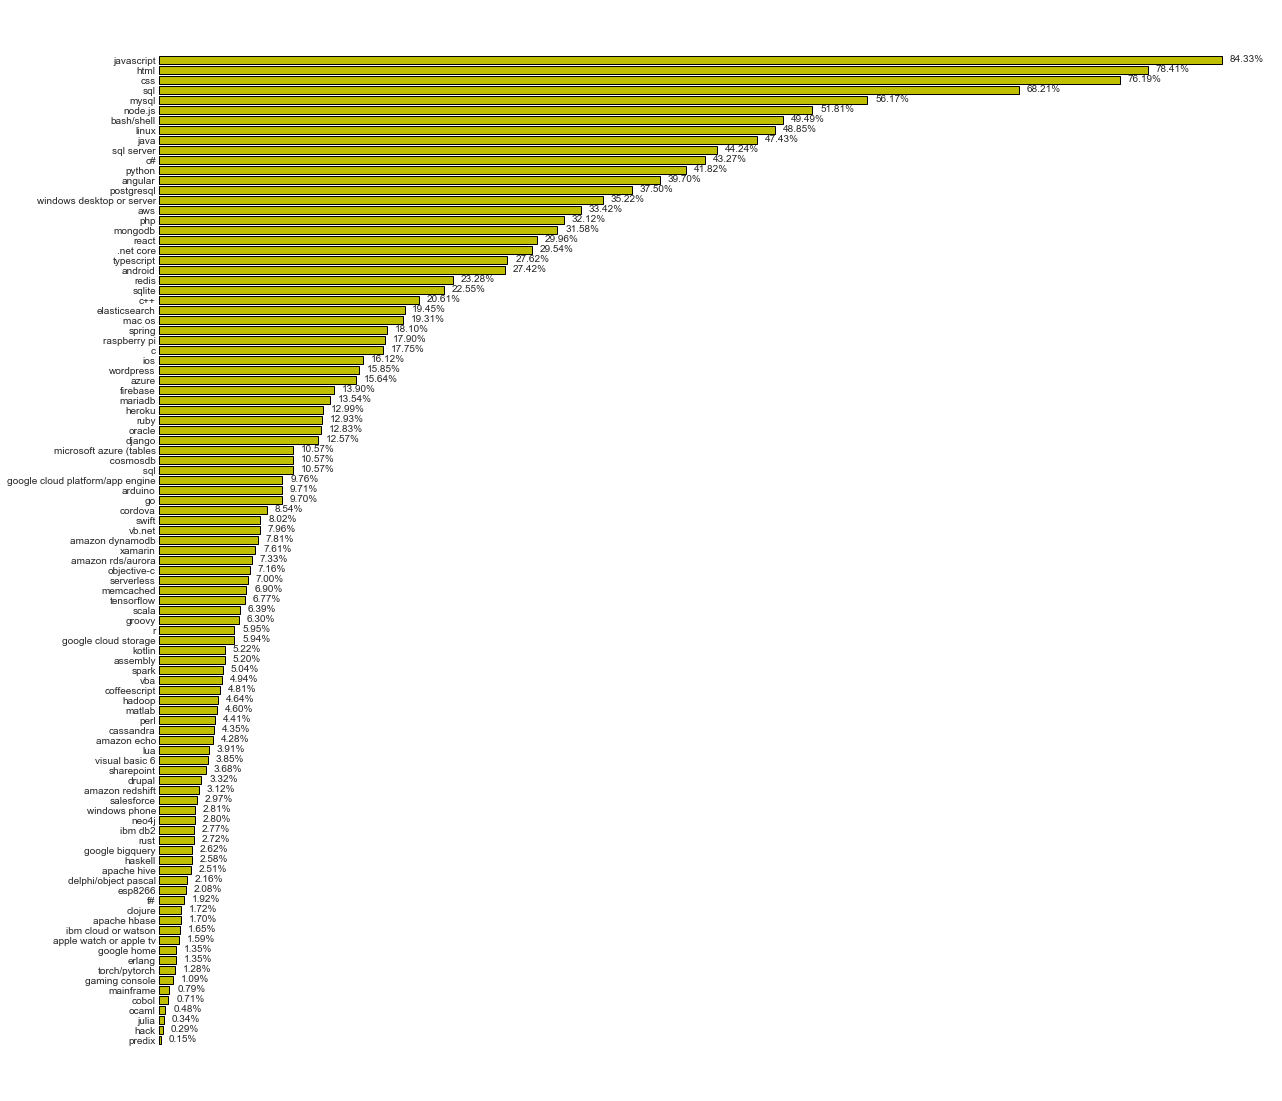

In [238]:
plt.style.use('seaborn-dark')

# current lw users
lw = {}
popular_skills=[]
rare_skills=[]
for x in Resume5.skills:
    for d in x:
        if d not in lw:
            lw[d] = 1   # create new instance
        else:
            lw[d] += 1  # increments that instance
lw = {k:v for k,v in sorted(lw.items(), key=lambda x:x[1])}
pos = np.arange(0,len(lw.keys()), 1)
labels = [x for x in lw.keys()]
tot = Resume5.skills.count()
pcnts = [round(100*x/tot, 2) for x in lw.values()]
for keys,values in lw.items():
    z= round(100*values/tot, 2)
    if(z>50.00):
        popular_skills.append(keys)
    elif(z<3.00):
        rare_skills.append(keys)



fig, ax = plt.subplots(figsize=(20,20))
fig.subplots_adjust(hspace=0.01)

ax.barh(labels, lw.values(), color='y', edgecolor='k')
ax.set_xticks(np.arange(0, max(lw.values())+600, 100))
ax.xaxis.set_ticklabels([])
for (y, p), x  in zip(enumerate(pcnts), lw.values()):
    ax.annotate("%.2f%%"%p, (x+100 ,y-0.125))
ax.xaxis.set_ticks_position('none')
ax.set_frame_on(False)
# prettify(ax)
# fig.tight_layout()

In [239]:
popular_skills

['node.js', 'mysql', 'sql', 'css', 'html', 'javascript']

In [240]:
rare_skills

['predix',
 'hack',
 'julia',
 'ocaml',
 'cobol',
 'mainframe',
 'gaming console',
 'torch/pytorch',
 'erlang',
 'google home',
 'apple watch or apple tv',
 'ibm cloud or watson',
 'apache hbase',
 'clojure',
 'f#',
 'esp8266',
 'delphi/object pascal',
 'apache hive',
 'haskell',
 'google bigquery',
 'rust',
 'ibm db2',
 'neo4j',
 'windows phone',
 'salesforce']

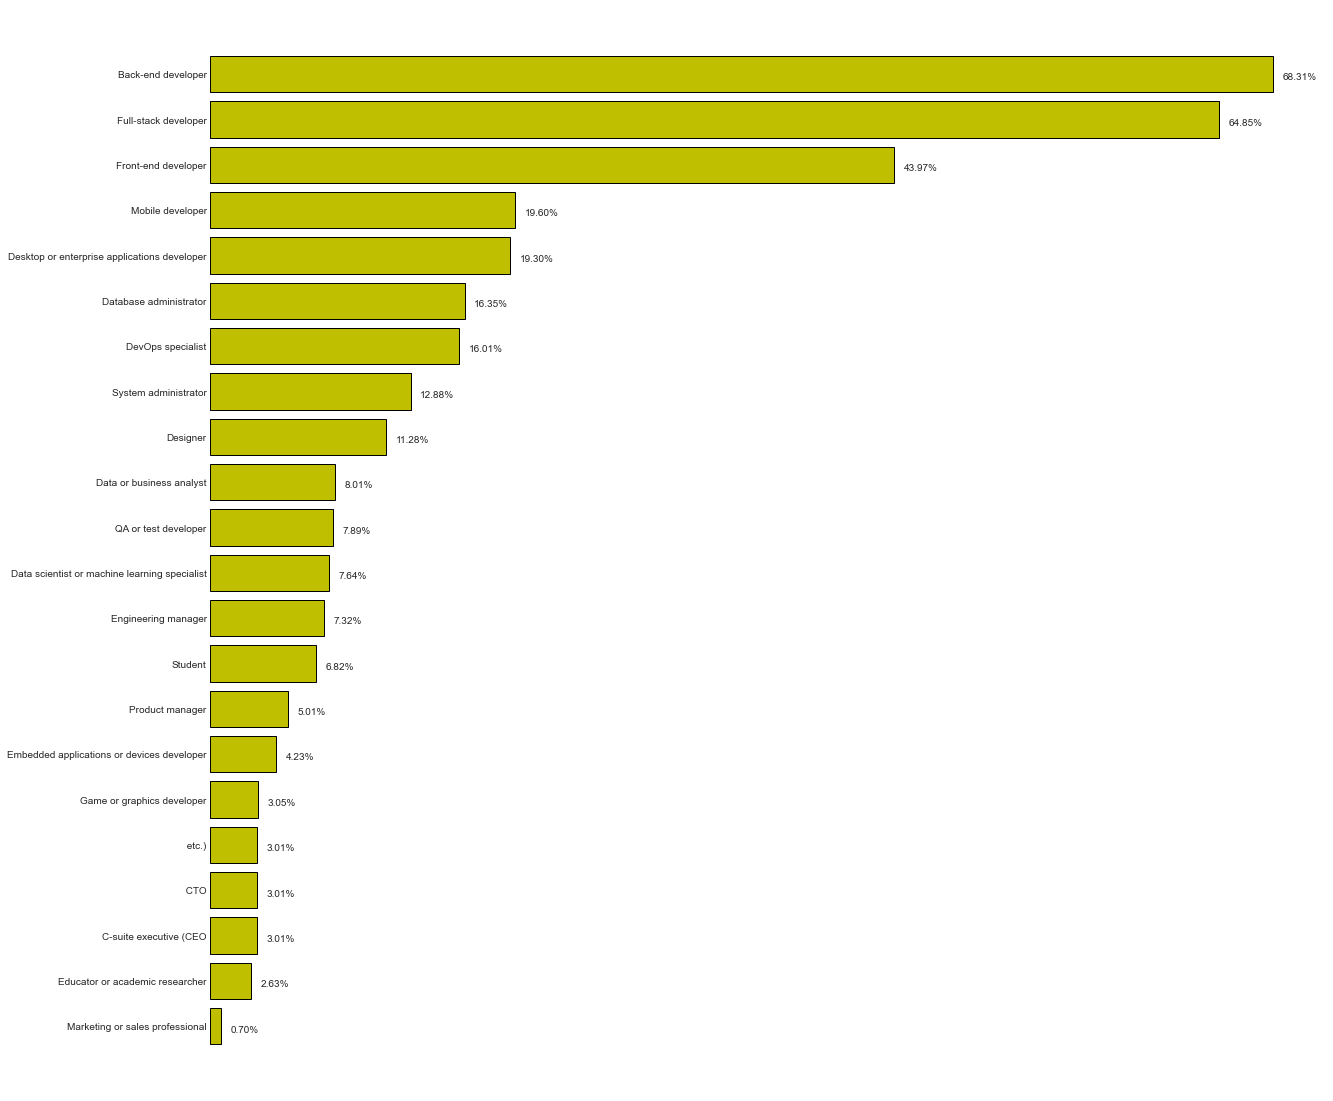

In [241]:
plt.style.use('seaborn-dark')

# current lw users
lw = {}
popular_dev=[]
rare_dev=[]
for x in Resume5.DevType:
    for d in x:
        if d not in lw:
            lw[d] = 1   # create new instance
        else:
            lw[d] += 1  # increments that instance           
lw = {k:v for k,v in sorted(lw.items(), key=lambda x:x[1])}
pos = np.arange(0,len(lw.keys()), 1)
labels = [x for x in lw.keys()]
tot = Resume5.DevType.count()
pcnts = [round(100*x/tot, 2) for x in lw.values()]
for keys,values in lw.items():
    z= round(100*values/tot, 2)
    if(z>50.00):
        popular_dev.append(keys)
    elif(z<3.00):
        rare_dev.append(keys)


fig, ax = plt.subplots(figsize=(20,20))
fig.subplots_adjust(hspace=0.01)

ax.barh(labels, lw.values(), color='y', edgecolor='k')
ax.set_xticks(np.arange(0, max(lw.values())+600, 100))
ax.xaxis.set_ticklabels([])
for (y, p), x  in zip(enumerate(pcnts), lw.values()):
    ax.annotate("%.2f%%"%p, (x+100 ,y-0.125))
ax.xaxis.set_ticks_position('none')
ax.set_frame_on(False)
# prettify(ax)
# fig.tight_layout()

In [242]:
popular_dev

['Full-stack developer', 'Back-end developer']

In [243]:
rare_dev

['Marketing or sales professional', 'Educator or academic researcher']

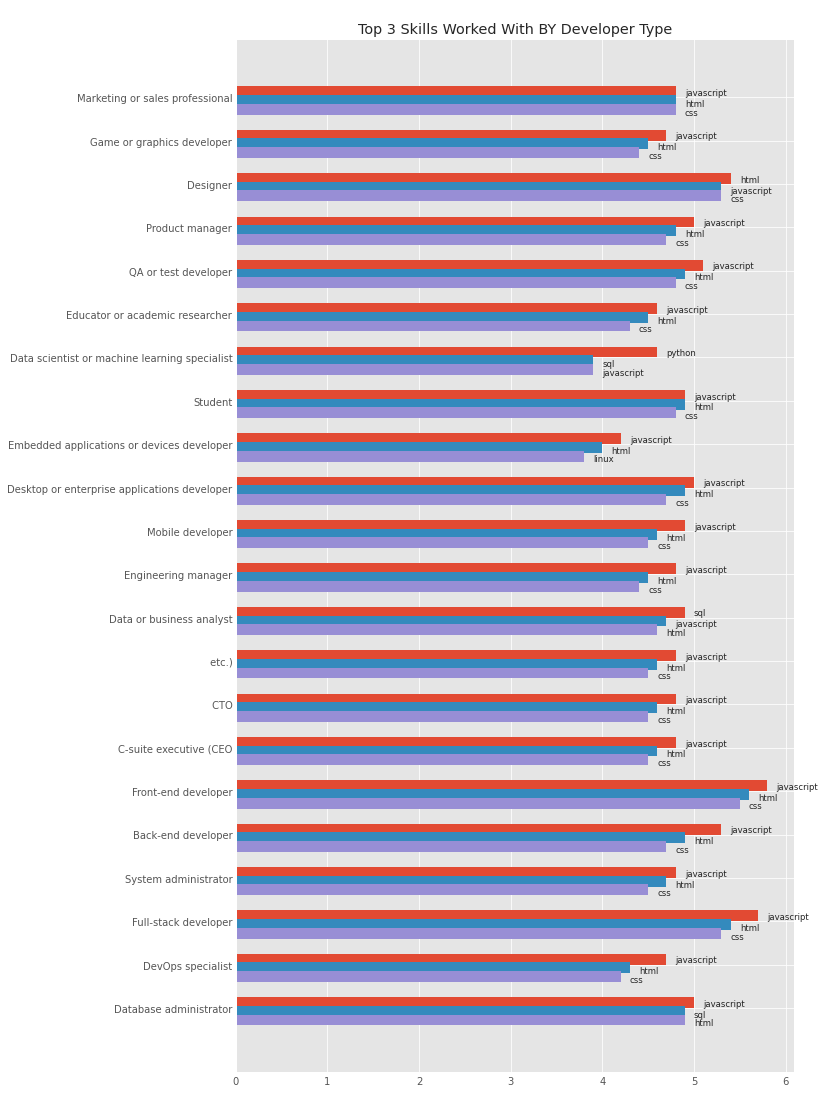

In [244]:
plt.style.use('ggplot')

dft = Resume5[['skills', 'DevType']]
# dft.skills.loc[0]
dl = {}

i = 0
for dev, lang in zip(dft.DevType, dft.skills):
  i+=1
  for d in dev:
    if d not in dl and d!='nan':
      dl[d] = dict()
    if d!='nan':
      for l in lang:
        if l not in dl[d]:
          dl[d][l] = 0
        else:
          dl[d][l] += 1
for d in dl.keys():
  temp = dl[d]
  temp = {k:v for k,v in sorted(temp.items(), key=lambda x:x[1])}
  temp = {k:round(100*v/sum(temp.values()),1) for k,v in temp.items()}
  dl[d] = temp


title = [n for n in dl.keys()]
nm1, nm2, nm3, n1, n2, n3 = [], [], [], [], [], []
for t in title:
    nm = [x for x in dl[t].values()]
    nam = [x for x in dl[t].keys()]
    nm1.append(nam[-1])
    nm2.append(nam[-2])
    nm3.append(nam[-3])
    n1.append(nm[-1])
    n2.append(nm[-2])
    n3.append(nm[-3])
n = np.arange(len(title))

fig, ax = plt.subplots(figsize=(10,19))
ax.barh(n, n1, height=0.25, align='edge')
ax.barh(n-0.2, n2, height=0.25, align='edge')
ax.barh(n-0.4, n3, height=0.25, align='edge')
ax.set_yticks(np.arange(len(title)))
ax.set_yticklabels([x for x in title])
for (y,_),x1, x2, x3, a1, a2, a3 in zip(enumerate(title), n1, n2, n3, nm1, nm2, nm3):
  ax.annotate(a1, (x1+0.1, y+0.05), fontsize=8.5)
  ax.annotate(a2, (x2+0.1, y-0.2), fontsize=8.5)
  ax.annotate(a3, (x3+0.1, y-0.4), fontsize=8.5)
ax.set_title('\nTop 3 Skills Worked With BY Developer Type')
# prettify(ax)

plt.style.use('default')

In [245]:
Resume6=Resume5;
for index,data in Resume6.iterrows():
    dev_val= data['DevType'][0]
    Resume6.at[index,'DevType']=dev_val 
Resume6.head(n=2)


,Respondent,Country,Student,CompanySize,Dependents,DevType,Gender,JobSatisfaction,LastNewJob,Salary_group,Salary,SalaryType,LanguageWorkedWith,DatabaseWorkedWith,PlatformWorkedWith,FrameworkWorkedWith,OperatingSystem,Age,skills
1,3,United Kingdom,No,"10,000 or more employees",Yes,Database administrator,Male,Moderately dissatisfied,More than 4 years ago,1501-5000,4250.0,Yearly,"JavaScript,Python,Bash/Shell","Redis,PostgreSQL,Memcached",Linux,Django,Linux-based,35 - 44 years old,"[postgresql, bash/shell, javascript, redis, py..."
6,9,United States,No,"10,000 or more employees",No,Back-end developer,Male,Slightly satisfied,Less than a year ago,5001-10000,10000.0,Yearly,"JavaScript,HTML,CSS",MongoDB,Linux,"Node.js,React",MacOS,18 - 24 years old,"[mongodb, css, html, node.js, javascript, reac..."


In [246]:
heat_map_dataset_bw_devtype_skills=Resume6[["DevType","skills"]]
heat_map_dataset_bw_devtype_skills=heat_map_dataset_bw_devtype_skills.head(n=50)

<AxesSubplot:ylabel='DevType'>

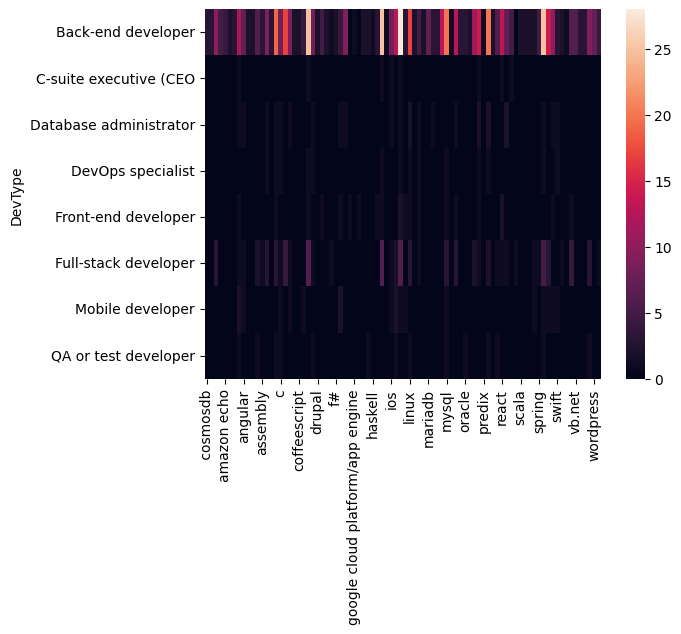

In [247]:
data = heat_map_dataset_bw_devtype_skills.groupby(["DevType"]).sum()
cols = np.unique(np.sum(heat_map_dataset_bw_devtype_skills["skills"]))

for col in cols:
    data[col] = 0
    
for idx in data.index:
    for col in data.loc[idx,"skills"]:
        data.loc[idx,col] += 1
        
sns.heatmap(data.iloc[:,1::])

In [248]:
Resume5.dtypes

Respondent                int64
Country                  object
Student                  object
CompanySize              object
Dependents               object
DevType                  object
Gender                   object
JobSatisfaction          object
LastNewJob               object
Salary_group           category
Salary                   object
SalaryType               object
LanguageWorkedWith       object
DatabaseWorkedWith       object
PlatformWorkedWith       object
FrameworkWorkedWith      object
OperatingSystem          object
Age                      object
skills                   object
dtype: object

### Build Graph on Neo4j


In [249]:
Resume6["DevType"].head(n=1)

1    Database administrator
Name: DevType, dtype: object

In [250]:
from neo4j import GraphDatabase
import logging
from neo4j.exceptions import ServiceUnavailable

class App:

    def __init__(self, uri, user, password):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))

    def close(self):
        # Don't forget to close the driver connection when you are finished with it
        self.driver.close()

    def create_friendship(self, person1_name,skillVal,gednerVal,osNameVal,countryNameVal,saleryVal,devTypeVal,ageVal,dependsVal):
        with self.driver.session() as session:
            # Write transactions allow the driver to handle retries and transient errors
            result = session.write_transaction(
                self._create_and_return_friendship, person1_name,skillVal,gednerVal,osNameVal,countryNameVal,saleryVal,devTypeVal,ageVal,dependsVal)
            for row in result:
                print("Created Node between: {p1}, {p2}".format(p1=row['p1'], p2=row['p2']))
            # for skills
            iter=9
            for skill in skillVal:
                result = session.write_transaction(
                    self._create_and_return_skillship, person1_name,skill,iter
                )
                iter+=1
                # for row in result:
                #     print("Created Node between: {p1}, {p2}".format(p1=row['p1'], p2=row['p2']))

    @staticmethod
    def _create_and_return_skillship(tx, person1_name, skill,iter):
        query = (
            "MERGE (p1:ResumeId { name: $person1_name }) "
        )
        query +=( " MERGE (p" + str(iter) + ":Skill { name:" + "$skill" + "})" )
        relationQuery=( "CREATE (p1)-[:knows]->(p"+str(iter) +")" )
        query+=relationQuery
        returnQueryVar="RETURN p"+str(iter)
        query+=returnQueryVar
        result = tx.run(query, person1_name=person1_name,skill=skill,iter=iter)
        try:
            return
            # print("from skillsjip")
            # print(result)
            # return [{"p1": row["p1"]["name"], "p2": row["p2"]["name"]}
            #         for row in result]
        # Capture any errors along with the query and data for traceability
        except ServiceUnavailable as exception:
            logging.error("{query} raised an error: \n {exception}".format(
                query=query, exception=exception))
            raise

    @staticmethod
    def _create_and_return_friendship(tx, person1_name, skillVal ,gednerVal,osNameVal,countryNameVal,saleryVal,devTypeVal,ageVal,dependsVal):
        # To learn more about the Cypher syntax, see https://neo4j.com/docs/cypher-manual/current/
        # The Reference Card is also a good resource for keywords https://neo4j.com/docs/cypher-refcard/current/
        query = (
            "MERGE (p1:ResumeId { name: $person1_name }) "
            "MERGE (p2:Gender { name: $gednerVal }) "
            "MERGE (p3:OperatingSystem { name: $osNameVal }) "
            "MERGE (p4:Country { name: $countryNameVal }) "
            "MERGE (p5:Salery { name: $saleryVal }) "
            "MERGE (p6:DevType { name: $devTypeVal }) "
            "MERGE (p7:Age { name: $ageVal }) "
            "MERGE (p8:Dependents { name: $dependsVal }) "
        )

        relationQuery=(
            "CREATE (p1)-[:isA]->(p2) "
            "CREATE (p1)-[:hasOs]->(p3) "
            "CREATE (p1)-[:livesIn]->(p4) "
            "CREATE (p1)-[:earns]->(p5) "
            "CREATE (p1)-[:worksOn]->(p6) "
            "CREATE (p1)-[:liesIn]->(p7) "
            "CREATE (p1)-[:has]->(p8) "
        )

        returnQueryVar="RETURN p1,p2,p3,p4,p5,p6,p7,p8"

        query+=relationQuery
        result = tx.run(query, person1_name=person1_name,skillVal=skillVal,gednerVal=gednerVal,osNameVal=osNameVal,countryNameVal=countryNameVal,saleryVal=saleryVal,devTypeVal=devTypeVal,ageVal=ageVal,dependsVal=dependsVal )
        query+=returnQueryVar
      
        
        try:
            return [{"p1": row["p1"]["name"], "p2": row["p2"]["name"]}
                    for row in result]
        # Capture any errors along with the query and data for traceability
        except ServiceUnavailable as exception:
            logging.error("{query} raised an error: \n {exception}".format(
                query=query, exception=exception))
            raise
        
    def find_person(self, person_name):
        with self.driver.session() as session:
            result = session.read_transaction(self._find_and_return_person, person_name)
            for row in result:
                print("Found person: {row}".format(row=row))

    @staticmethod
    def _find_and_return_person(tx, person_name):
        query = (
            "MATCH (p:Person) "
            "WHERE p.name = $person_name "
            "RETURN p.name AS name"
        )
        result = tx.run(query, person_name=person_name)
        return [row["name"] for row in result]


# if __name__ == "__main__":
#     # Aura queries use an encrypted connection using the "neo4j+s" URI scheme
#     uri = "neo4j://localhost:7687"
#     user = "neo4j"
#     password = "amit"
#     app = App(uri, user, password)
#     for index,rows in Resume5.iterrows():
#         resId=rows['Respondent'] 
#         skillVal=rows['skills']
#         gednerVal=rows['Gender']
#         osNameVal=rows['OperatingSystem']
#         countryNameVal=rows['Country']
#         saleryVal=rows['Salary']
#         devTypeVal=rows['DevType']
#         ageVal=rows['Age']
#         dependsVal=rows['Dependents']
#         # print(resId,gednerVal)
#         app.create_friendship(resId,skillVal,gednerVal,osNameVal,countryNameVal,saleryVal,devTypeVal,ageVal,dependsVal)
#     app.find_person("India")
#     app.close()